This notebook is used to create histograms of the distances between FISH molecule centers (given as csv - done with RS-FISH) to the closest protein of interest.  
One histogram is made per protein condition. Each protein condition has multiple images.  

It's done by iterating over each condition directory and then:
* Iterating over each tif image in the directory. For each image:
1. Read the image and take only the protein channel automatically (need to see how) 
2. Thresholding the image - currently either Otsu or a manually given threshold. Creating a binary image of protein vs background.
3. Create a min distance map of each pixel to a protein pixel.
4. Read FISH spot location CSV.
5. For each spot location - get it's value in the distance map image (thus its minimum distance to protein.
* Save condition distances (from all its images) to CSV in results directory.
* Save condition distances histogram plot to png.

Current considerations:  
* Int spot locations are used (causing a bit of a less accurate approach).
* Image channel used is guessed ..

In [1]:
from glob import glob
import os
import numpy as np
from scipy.ndimage import distance_transform_edt
from scipy import interpolate
from skimage import filters
import tifffile as tif
import matplotlib.pyplot as plt
from matplotlib import ticker
from datetime import datetime
import pandas as pd
import logging

In [2]:
DEBUG = True

In [3]:
def set_logger():
    logger = logging.getLogger()
    logger.setLevel(logging.INFO)
    logging.info("Starting")

In [4]:
def view_condition_images(dir, img_num, channel=0):
    path = glob(os.path.join(dir,f'*-{img_num}.tif'))[0]
    logging.info(path)
    img = tif.imread(path)
    logging.info(img.shape)
    img = img[:,:,channel]
    plt.imshow(img)

In [5]:
def create_result_dir():
    now = datetime.now()
    timestamp_str = now.strftime("%Y%m%d_%H%M%S")
    dir_name = f'distance_analysis_{timestamp_str}'
    result_path = os.path.join(parent_dir_path, dir_name)
    os.makedirs(result_path)
    
    return result_path

In [6]:
def read_img_channel(path, channel=0):
    try:
        img = tif.imread(path)[:,:,channel]
    except IndexError:
        logging.warning(f'Skipping image as it doesnt have channel {channel}. Path: {path}.')
        return None
        
    return img

In [7]:
def get_thresholded_img(img, thr='otsu'):
    
    if thr == 'otsu':
        thr = filters.threshold_otsu(img)
        
    thresholded_img = img < thr
    
    if np.sum(thresholded_img) < thresholded_img.size//2:
        logging.warning('Thresholded image has more pixels of object than background.' /
                        'Please check that the thresholding didnt reverse the background and object values')

    return thresholded_img

In [8]:
def get_distance_map(bw_img):
    #img_inv = np.logical_not(bw_img)
    dist_map = distance_transform_edt(bw_img)
    return dist_map

In [9]:
def get_img_fish_spots(img_num, csv_paths):
    
    csv_path = [p for p in csv_paths if f'{img_num}.csv' in p]
    
    try:
        df = pd.read_csv(csv_path[0])
    except (FileNotFoundError, IndexError) as Error:
        logging.warning(f'Skipping image as fist csv is missing. Image num: {img_num}.')
        return None
            
    #spots_arr = np.rint(df[["y","x"]].to_numpy()).astype(int)
    spots_arr = df[["y","x"]].to_numpy()
    
    return spots_arr

In [10]:
def get_spots_distances(spots, dist_map):
    
    distances = []
    
    for x,y in spots:
        
        x1, y1 = int(x), int(y)
        x2, y2 = int(np.ceil(x)), int(np.ceil(y))
        
        # 4 pixels involved in the interpolation
        Q11 = dist_map[x1, y1]
        Q12 = dist_map[x1, y2]
        Q21 = dist_map[x2, y1]
        Q22 = dist_map[x2, y2]

        # Bilinear interpolation formula
        interpolated_value = Q11 * (x2 - x) * (y2 - y) + \
                            Q21 * (x - x1) * (y2 - y) + \
                            Q12 * (x2 - x) * (y - y1) + \
                            Q22 * (x - x1) * (y - y1)

        distances.append(interpolated_value)

    return distances


In [11]:
def plot_and_save_condition_histogram(pixel_distances, plot_path, c):

    bin_size = 0.1
    
    conversion_factor = 4.615 # a micrometer is 4.615 pixels
    mm_distances = [dist / conversion_factor for dist in pixel_distances]

    # Create histogram without density=True, capturing the returned values
    counts, bin_edges = np.histogram(mm_distances, bins=np.arange(min(mm_distances), 
                                                                  max(mm_distances) + bin_size, bin_size))

    # Calculate percentage for each bin
    counts_percentage = counts / sum(counts)

    # Plot the histogram using plt.bar instead of plt.hist
    plt.bar(bin_edges[:-1], counts_percentage, align='center', width=bin_size)

    # Set the x-ticks to be at the middle of the bins
    plt.xticks(bin_edges[:-1], rotation=45)

    # Format y-axis as percentage
    plt.gca().yaxis.set_major_formatter(ticker.PercentFormatter(1.0))

    # Label the axes
    plt.xlabel('Distance (μm)')
    plt.ylabel('Percentage') #('Count')
    
    title = f'Distance of FISH spots from protein {c}' if DEBUG \
            else f'Distance of FISH spots from protein {c.split(" ")[1]}'
    plt.title(title)

    plt.savefig(plot_path, bbox_inches='tight')
    # Show the plot in the Jupyter notebook
    plt.show()

INFO:root:Starting
INFO:root:Processing condition: example_data
INFO:root:Number of files to be processed: 2
INFO:root:Number of csv paths: 2


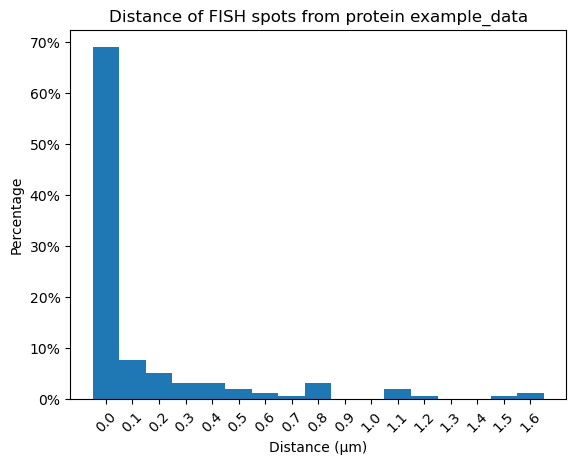

In [12]:

set_logger()

parent_dir_path = ''
conditions_dirs = ['crop homer1', 'cdrop vglut1', 'crop psd95', 'crop synapsin1'] if not DEBUG else ['example_data']
conditions_thresholds = ['otsu', 'otsu', 'otsu', 'otsu']

result_path = create_result_dir()

pri
for ic,c in enumerate(conditions_dirs):

    logging.info(f'Processing condition: {c}')
    imgs_paths = glob(os.path.join(parent_dir_path, c, '*.tif'))
    logging.info(f'Number of files to be processed: {len(imgs_paths)}')
    csv_paths = glob(os.path.join(parent_dir_path, c, '*.csv'))
    logging.info(f'Number of csv paths: {len(csv_paths)}')

    condition_distances = []

    for p in imgs_paths:
        
        #logging.info(f'processing image: {p}')
        img_num = p.split('-')[1].split('.tif')[0].replace(" ","")

        img = read_img_channel(p)
        if img is None:
            continue

        thr_img = get_thresholded_img(img, conditions_thresholds[ic])
        dist_map = get_distance_map(thr_img)

        spots = get_img_fish_spots(img_num, csv_paths) 
        if spots is None:
            continue

        condition_distances.extend(get_spots_distances(spots, dist_map))


    pd.DataFrame(condition_distances, 
                 columns=['distances']).to_csv(os.path.join(result_path, 
                                                            f'distances_{c}.csv'), index=False)
    plot_and_save_condition_histogram(condition_distances, os.path.join(result_path, f'{c}.png'), c)
